<a href="https://colab.research.google.com/github/DanBaissa/symbolic_regression_polisci/blob/main/Symbolic_Regression_Political_Science_Edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression in Political Science
---

## Overview

This educational notebook demonstrates how **symbolic regression**, a machine learning technique that automatically discovers mathematical equations—can help political scientists and social scientists uncover the underlying functional relationships in data. Instead of pre-selecting a model form (like linear or quadratic), symbolic regression explores a huge space of possible equations and finds the one(s) that best fit the observed data. This makes it especially useful for:

- Detecting non-linearities, thresholds, and cycles that traditional regressions may miss.
- Revealing interaction effects and complex dynamics.
- Providing **interpretable formulas** instead of black-box predictions.

The notebook combines classic social science and political economy data-generating processes (linear, quadratic, interaction, cyclical) and demonstrates how symbolic regression can discover these relationships using two tools:

- Python’s `gplearn` (genetic programming)
- Julia’s `PySR` (highly efficient, often simpler equations)

For each dataset, you’ll see:

- The context and political science analogy
- The discovered formula (compared to the “ground truth”)
- The test-set fit (R²)
- Example paper-style writeups for interpreting your findings

#### Installation and Imports

In [1]:
!pip install gplearn pysr julia ace_tools
import julia
julia.install()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from pysr import PySRRegressor
from IPython.display import display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.3/99.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.7 MB/s eta 0:00:00



Precompiling PyCall...
Precompiling PyCall... DONE
PyCall is installed and built successfully.


[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Using Julia 1.10.9 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Writing Project.toml:
             [deps]
             SymbolicRegression = "8254be44-1295-4e6a-a16d-46603ac705cb"
             Serialization = "9e88b42a-f829-5b0c-bbe9-9e923198166b"
             PythonCall = "6099a3de-0909-46bc-b1f4-468b9a2dfc0d"
             OpenSSL_jll = "458c3c95-2e84-50aa-8efc-19380b2a3a95"
             [compat]
             SymbolicRegression = "~1.11"
             Serialization = "^1"
             PythonCall = "=0.9.25"
             OpenSSL_jll = "~3.0"
[juliapkg] Installing packages:
             import Pkg
    

In [2]:
!git clone https://github.com/DanBaissa/symbolic_regression_polisci.git
%cd symbolic_regression_polisci

Cloning into 'symbolic_regression_polisci'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 1.83 MiB | 4.29 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/symbolic_regression_polisci


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Synthetic Datasets for Regression and Causal Inference

This notebook creates a series of classic and causal inference datasets to illustrate various regression and identification strategies commonly encountered in econometrics, statistics, and data science. The code generates these datasets with noise to better simulate real-world data.

## Classic Regression Models

### 1. Linear Model

This is the most basic regression scenario: a straight-line relationship with added Gaussian noise.

**Equation:**

$$
y = 2.5x + 3 + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.1^2)
$$

* **Interpretation:** The outcome \$y\$ increases linearly with \$x\$.

---

### 2. Quadratic Model

This model introduces a non-linear (parabolic) relationship.

**Equation:**

$$
y = -1.2x^2 + 2x + 1 + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.1^2)
$$

* **Interpretation:** \$y\$ is maximized at some value of \$x\$ and decreases on either side—a classic parabola.

---

### 3. Interaction Model

This model includes two predictors, \$x\_1\$ and \$x\_2\$, and their interaction.

**Equation:**

$$
y = 1.5\,x_1x_2 + 0.5\,x_2 + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.1^2)
$$

* **Interpretation:** The effect of \$x\_1\$ on \$y\$ depends on the value of \$x\_2\$ (interaction effect).

---

### 4. Sinusoidal Model

This model simulates a periodic (sinusoidal) relationship, which is common in time series or physics.

**Equation:**

$$
y = 1.8\,\sin(1.5x) + 0.2x + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.1^2)
$$

* **Interpretation:** \$y\$ oscillates in a wave-like pattern as \$x\$ increases, with a slight linear trend.

---

## Causal Inference Models

### 5. Difference-in-Differences (DiD)

This model simulates a classic causal identification design, where treatment and post-treatment periods interact.

**Variables:**

* \$D\$ (treatment indicator): 1 if \$x > 0\$, else 0
* \$P\$ (post indicator): 1 if "post" period, else 0
* \$D \times P\$ (interaction)

**Equation:**

$$
y = 2D + 1.5P + 3(D \times P) + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.5^2)
$$

* **Interpretation:** The coefficient on \$D \times P\$ (\$=3\$) is the *treatment effect* in the DiD framework.

---

### 6. Sharp Regression Discontinuity (Sharp RD)

This model creates a discontinuity (a "jump") at \$x = 0\$.

**Equation:**

$$
y = 2 + 3 \cdot \mathbb{I}[x \geq 0] + 0.5x + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.3^2)
$$

where \$\mathbb{I}\[\cdot]\$ is the indicator function (1 if condition is true, 0 otherwise).

* **Interpretation:** There is an immediate increase of 3 units in \$y\$ when \$x\$ crosses zero from the left.

---

### 7. Fuzzy Regression Discontinuity (Fuzzy RD)

Instead of a sharp cutoff, here the probability of receiving treatment changes smoothly at \$x=0\$.

* **Treatment probability:** \$\Pr(\text{treatment}) = \frac{1}{1 + \exp(-10x)}\$

**Equation:**

$$
y = 1.5\,T + 0.5x + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.3^2)
$$

where \$T\$ is a randomly assigned treatment based on the above probability.

* **Interpretation:** Not everyone above the threshold gets treated, but the probability jumps sharply at \$x=0\$.

---

### 8. Instrumental Variables (IV)

This simulates a classic IV scenario:

* \$Z\$: Binary instrument (\$0\$ or \$1\$)
* \$X\$: Endogenous regressor, affected by \$Z\$

**First stage:**

$$
x = 0.7z + \nu, \quad \nu \sim \mathcal{N}(0, 0.1^2)
$$

**Second stage (outcome):**

$$
y = 2.0x + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.3^2)
$$

* **Interpretation:** \$Z\$ affects \$X\$, and \$X\$ affects \$Y\$, but \$Z\$ does not directly affect \$Y\$ except through \$X\$.


In [ ]:
rng = np.random.default_rng(42)
X = np.linspace(-3, 3, 200).reshape(-1, 1)

# Classic models
y_linear = 2.5 * X.ravel() + 3 + rng.normal(0, 0.1, X.shape[0])
y_quadratic = -1.2 * (X.ravel() ** 2) + 2 * X.ravel() + 1 + rng.normal(0, 0.1, X.shape[0])
X2 = rng.uniform(-3, 3, X.shape[0])
y_interaction = 1.5 * X.ravel() * X2 + 0.5 * X2 + rng.normal(0, 0.1, X.shape[0])
y_sinusoidal = 1.8 * np.sin(1.5 * X.ravel()) + 0.2 * X.ravel() + rng.normal(0, 0.1, X.shape[0])

# Causal inference models
# Difference-in-Differences
treatment = (X.ravel() > 0).astype(int)
post = (rng.uniform(-1, 1, X.shape[0]) > 0).astype(int)
interaction = treatment * post
y_did = 2 * treatment + 1.5 * post + 3 * interaction + rng.normal(0, 0.5, X.shape[0])
X_did = np.column_stack([treatment, post, interaction])

# Sharp RD
X_rd = X.ravel()
y_rd = 2 + 3 * (X_rd >= 0).astype(int) + 0.5 * X_rd + rng.normal(0, 0.3, X.shape[0])
X_rd = X_rd.reshape(-1, 1)

# Fuzzy RD
treatment_prob = 1 / (1 + np.exp(-10 * X.ravel()))
fuzzy_treatment = rng.binomial(1, treatment_prob)
y_fuzzy_rd = 1.5 * fuzzy_treatment + 0.5 * X.ravel() + rng.normal(0, 0.3, X.shape[0])
X_fuzzy = X

# Instrumental Variables
Z = rng.integers(0, 2, size=X.shape[0])
X_iv = 0.7 * Z + rng.normal(0, 0.1, X.shape[0])
y_iv = 2.0 * X_iv + rng.normal(0, 0.3, X.shape[0])
X_iv_stack = np.column_stack([X_iv, Z])

# Bundle everything
datasets = [
    ("Linear", X, y_linear, None),
    ("Quadratic", X, y_quadratic, None),
    ("Interaction", np.column_stack([X.ravel(), X2]), y_interaction, X2),
    ("Sinusoidal", X, y_sinusoidal, None),
    ("Diff-in-Diff", X_did, y_did, None),
    ("Sharp RD", X_rd, y_rd, None),
    ("Fuzzy RD", X_fuzzy, y_fuzzy_rd, None),
    ("Instrumental Vars", X_iv_stack, y_iv, None)
]


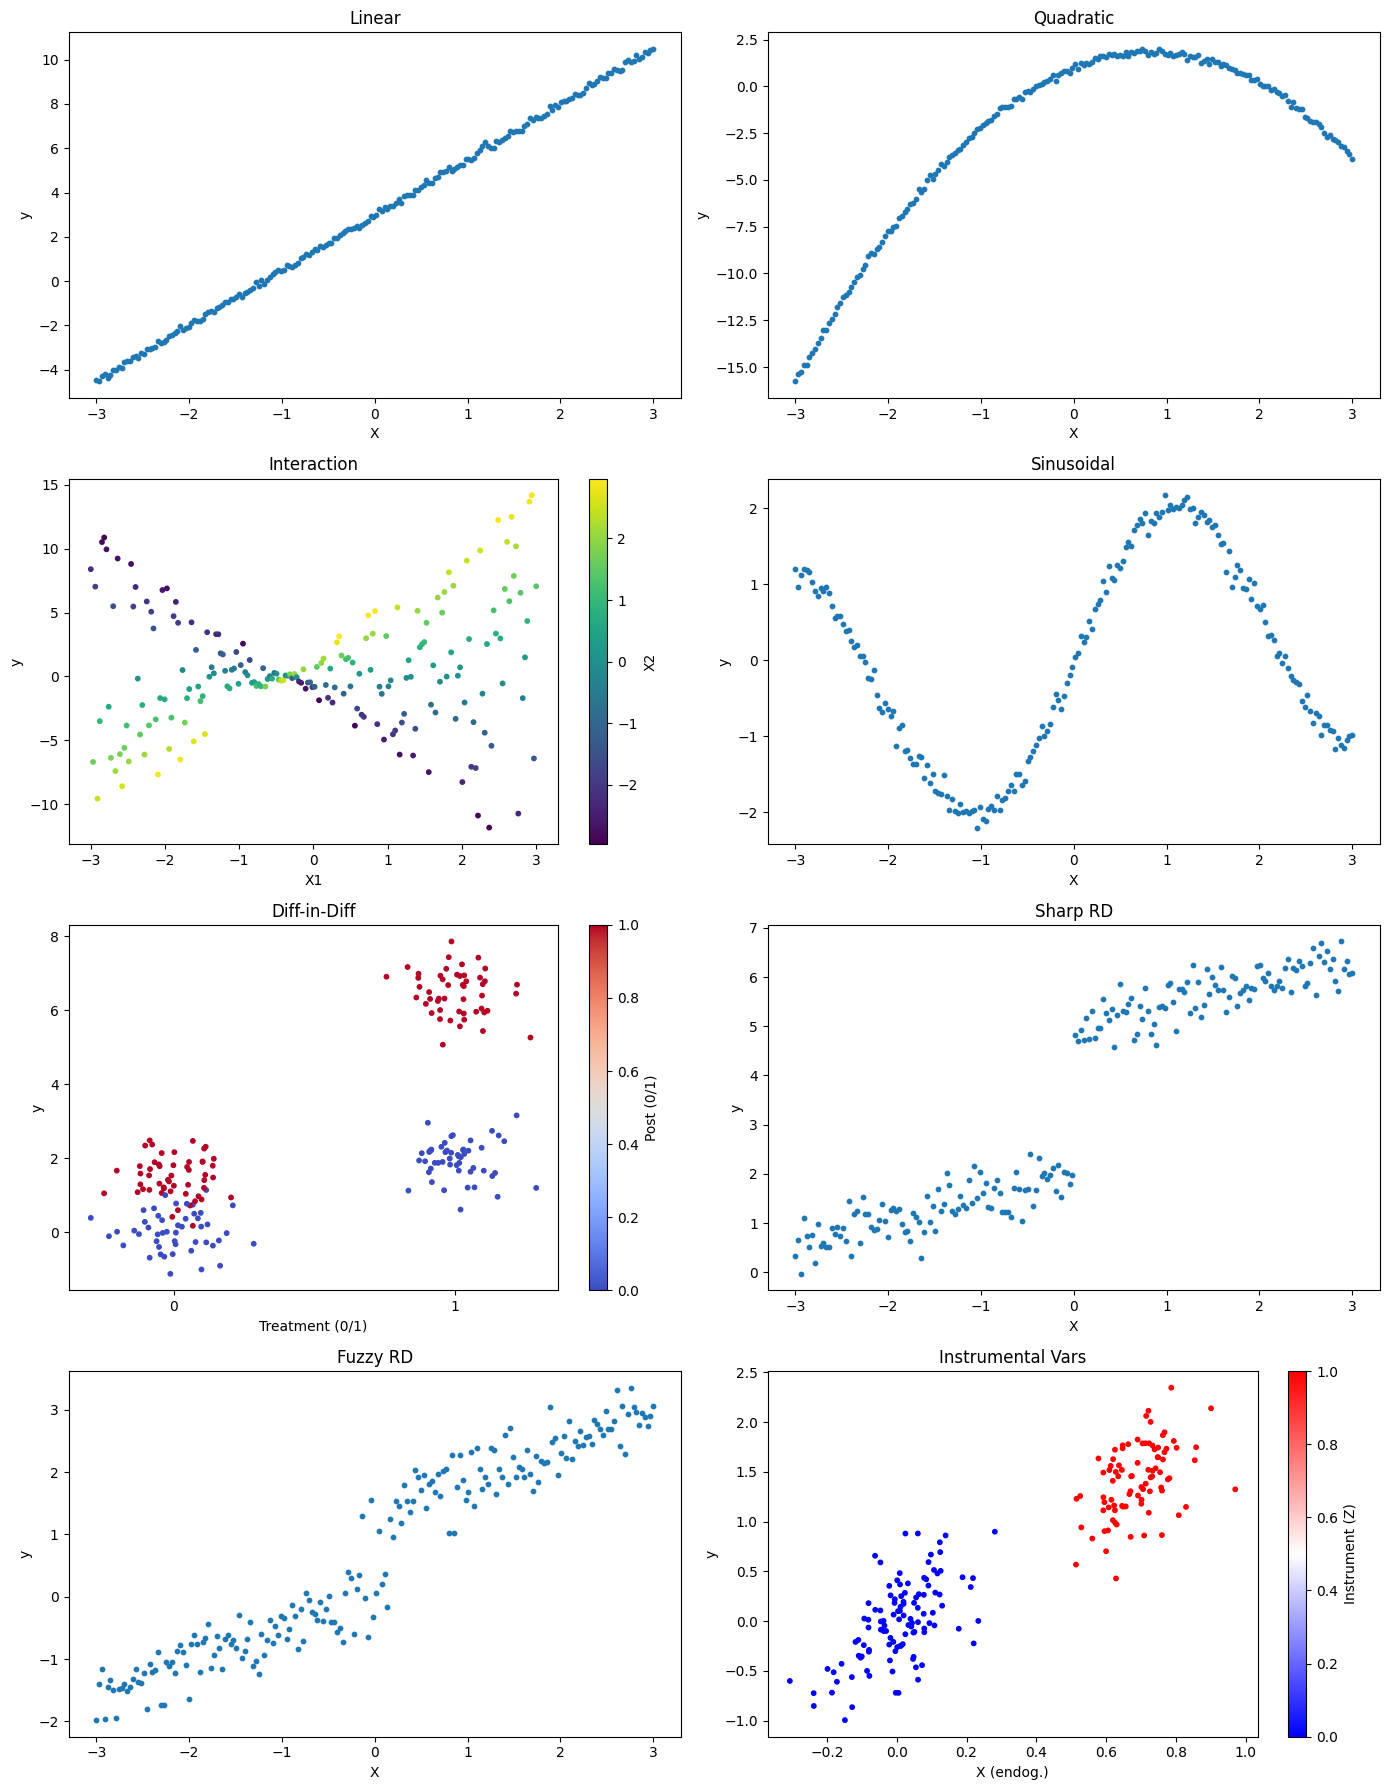

In [ ]:
# Plot
fig, axes = plt.subplots(4, 2, figsize=(14, 18))
axes = axes.ravel()

for i, (name, X_data, y_data, extra) in enumerate(datasets):
    ax = axes[i]
    # Choose the appropriate x-axis
    if name == "Interaction":
        # Plot as a scatter of X1 vs y, colored by X2
        sc = ax.scatter(X_data[:, 0], y_data, c=X_data[:, 1], cmap='viridis', s=10)
        ax.set_xlabel("X1")
        ax.set_ylabel("y")
        plt.colorbar(sc, ax=ax, label="X2")
    elif name == "Diff-in-Diff":
        # Show treatment=0 vs treatment=1
        ax.scatter(X_data[:, 0] + 0.1 * np.random.randn(len(X_data)), y_data,
                   c=X_data[:, 1], cmap='coolwarm', s=10)
        ax.set_xlabel("Treatment (0/1)")
        ax.set_ylabel("y")
        ax.set_xticks([0, 1])
        plt.colorbar(ax.collections[0], ax=ax, label="Post (0/1)")
    elif name == "Instrumental Vars":
        # Scatterplot: X_iv vs y, colored by Z
        sc = ax.scatter(X_data[:, 0], y_data, c=X_data[:, 1], cmap='bwr', s=10)
        ax.set_xlabel("X (endog.)")
        ax.set_ylabel("y")
        plt.colorbar(sc, ax=ax, label="Instrument (Z)")
    else:
        ax.scatter(X_data.ravel(), y_data, s=10)
        ax.set_xlabel("X")
        ax.set_ylabel("y")
    ax.set_title(name)

plt.tight_layout()
plt.show()

## Symbolic Regression with `gplearn`

In this section, we use [**symbolic regression**](https://gplearn.readthedocs.io/en/stable/) to automatically discover mathematical equations that best describe the relationships in our synthetic datasets. Symbolic regression differs from traditional regression in that it does **not** require the user to specify the functional form in advance (e.g., linear, quadratic). Instead, it searches over many possible mathematical expressions to find the best-fitting equation.

We use the [`gplearn`](https://gplearn.readthedocs.io/en/stable/) library in Python, which applies **genetic programming** to evolve symbolic expressions that fit the data.

### Code Overview

For each synthetic dataset:

1. **Train/Test Split:** We split the data into training and testing sets.
2. **Symbolic Regression:** We fit a `SymbolicRegressor` model to the training data.
3. **Equation Discovery:** The regressor evolves and outputs the best-fitting symbolic equation it discovers.
4. **Performance Evaluation:** We compute the \$R^2\$ (coefficient of determination) on the test set.
5. **Plotting:** We plot the predicted values against the actual test values to visualize the fit.

### Key Parameters Used

* **`population_size` and `generations`:** Control how many candidate solutions are generated and how many times they evolve.
* **`parsimony_coefficient`:** Penalizes complexity, encouraging simpler equations.
* **`p_crossover`, `p_subtree_mutation`, etc.:** Set rates for how solutions mutate and combine, analogous to genetic evolution.

### Results: Equations and Fit

For each dataset, we:

* Print the discovered symbolic equation.
* Print the test-set \$R^2\$ score (how well the equation generalizes).
* Visualize the fit using a scatterplot: predicted vs. actual values.

A perfect fit would place all points on the red dashed line (the 45-degree “Ideal Fit” line).

#### Example Output (for one dataset)

```
=== Linear (Python/gplearn) ===
Discovered equation (Python): add(mul(2.48, X0), 2.95)
Test set R^2: 0.999
```

The plot for this dataset would show nearly all points clustered on the ideal line, indicating that symbolic regression has recovered the original linear relationship.

### Interpreting the Plots

* **Scatter close to the red line:** Model fits well; discovered equation likely captures the true relationship.
* **Scatter far from the line:** The discovered equation may be mis-specified, too complex/simple, or the data are inherently noisy or non-deterministic.

---

This process allows us to **reverse engineer** functional relationships from data, even when the underlying equations are unknown—a powerful tool for scientific discovery and interpretability.



=== Linear (Python/gplearn) ===
Discovered equation (Python): mul(add(0.991, add(X0, 0.194)), div(0.991, 0.394))
Test set R^2: 1.000


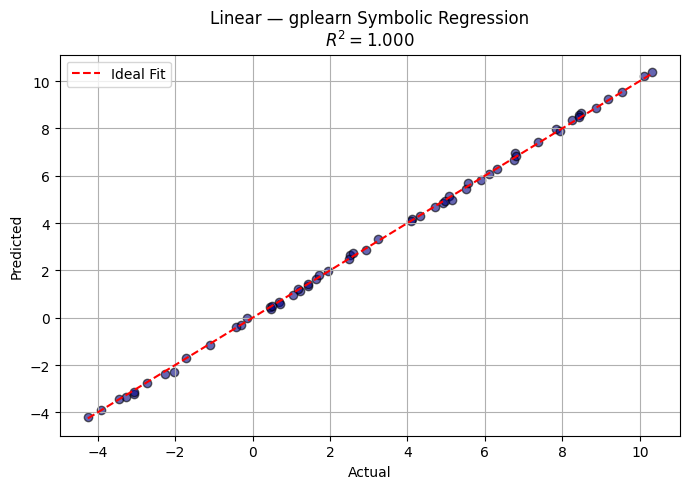


=== Quadratic (Python/gplearn) ===
Discovered equation (Python): sub(add(sub(0.817, X0), add(X0, 0.138)), add(add(mul(X0, X0), mul(-0.693, X0)), add(mul(-0.963, X0), mul(-0.223, add(sub(X0, mul(add(0.388, X0), X0)), sub(X0, -0.428))))))
Test set R^2: 0.999


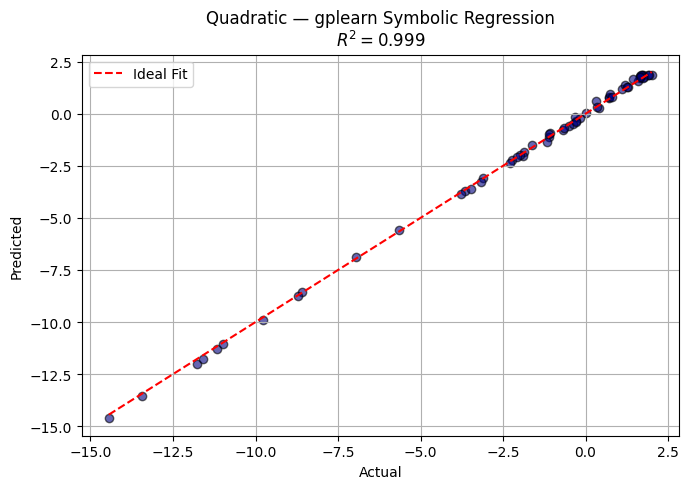


=== Interaction (Python/gplearn) ===
Discovered equation (Python): mul(add(0.633, sub(add(X0, X0), mul(0.662, mul(0.662, X0)))), X1)
Test set R^2: 0.995


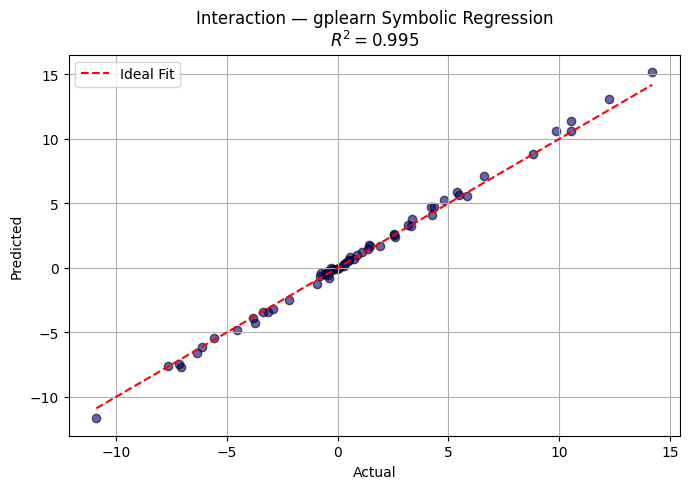


=== Sinusoidal (Python/gplearn) ===
Discovered equation (Python): div(div(add(X0, X0), X0), sub(X0, div(-0.487, X0)))
Test set R^2: 0.691


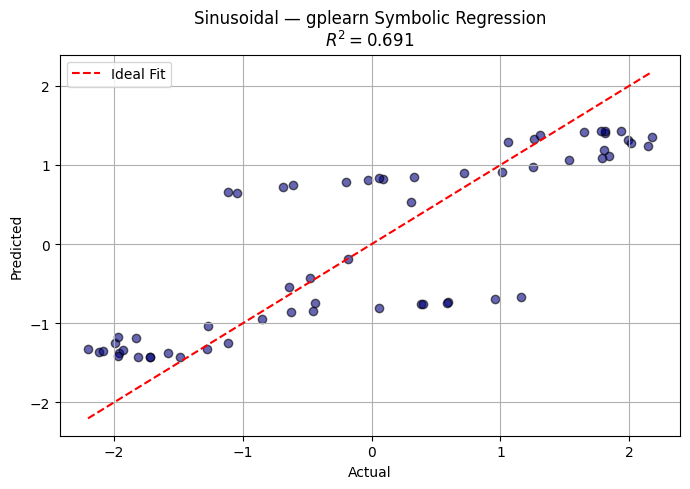


=== Diff-in-Diff (Python/gplearn) ===
Discovered equation (Python): mul(add(X1, X0), add(add(X1, X0), add(0.201, X0)))
Test set R^2: 0.953


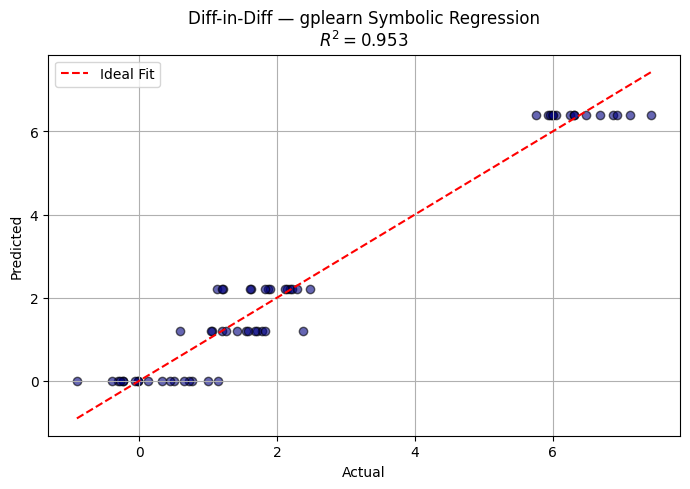


=== Sharp RD (Python/gplearn) ===
Discovered equation (Python): add(div(0.980, 0.362), add(0.832, div(X0, 0.832)))
Test set R^2: 0.845


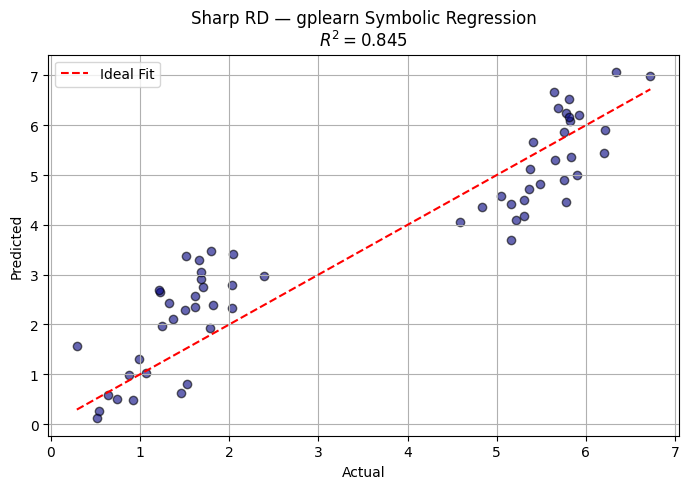


=== Fuzzy RD (Python/gplearn) ===
Discovered equation (Python): add(0.727, mul(0.859, X0))
Test set R^2: 0.898


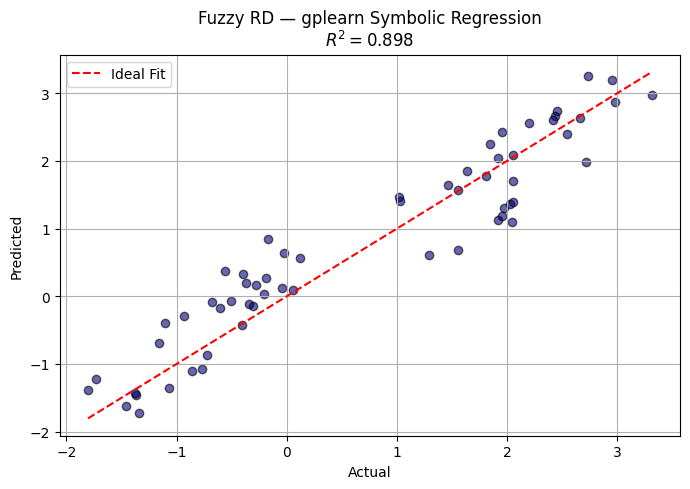


=== Instrumental Vars (Python/gplearn) ===
Discovered equation (Python): add(X0, X0)
Test set R^2: 0.847


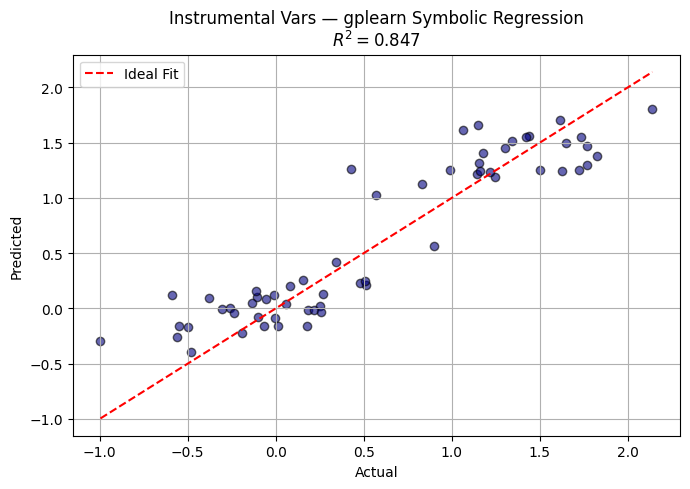

In [ ]:
import matplotlib.pyplot as plt

gplearn_results = []

for name, X_data, y_data, _ in datasets:
    print(f"\n=== {name} (Python/gplearn) ===")
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
    py_est = SymbolicRegressor(
        population_size=1000,
        generations=20,
        stopping_criteria=0.01,
        p_crossover=0.7,
        p_subtree_mutation=0.1,
        p_hoist_mutation=0.05,
        p_point_mutation=0.1,
        max_samples=0.9,
        verbose=0,
        parsimony_coefficient=0.01,
        random_state=0
    )
    py_est.fit(X_train, y_train)
    y_pred_py = py_est.predict(X_test)
    py_r2 = r2_score(y_test, y_pred_py)
    py_eq = str(py_est._program)
    print(f"Discovered equation (Python): {py_eq}")
    print(f"Test set R^2: {py_r2:.3f}")
    gplearn_results.append({'name': name, 'eq': py_eq, 'r2': py_r2})

    # === PLOTTING ===
    plt.figure(figsize=(7,5))
    plt.scatter(y_test, y_pred_py, alpha=0.6, color='navy', edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
    plt.title(f"{name} — gplearn Symbolic Regression\n$R^2 = {py_r2:.3f}$")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


## Symbolic Regression with PySR (Julia Engine)

In this section, we repeat the symbolic regression analysis using [`PySR`](https://github.com/MilesCranmer/PySR), a Python interface to a fast symbolic regression engine written in Julia. PySR uses evolutionary algorithms and powerful heuristics to discover concise, interpretable mathematical expressions that fit the data.

While `gplearn` is pure Python, **PySR leverages Julia for improved speed and search capability**, often recovering more accurate or simpler expressions, especially for challenging functional forms.

### Code Workflow

For each synthetic dataset:

1. **Train/Test Split:** Data is split into training and test sets.
2. **Symbolic Regression:** The `PySRRegressor` is trained on the training set.
3. **Equation Discovery:** PySR searches a vast space of mathematical expressions and selects the "best" equation based on fit and simplicity (parsimony).
4. **Performance Evaluation:** The resulting equation is evaluated on the test set and the \$R^2\$ score is reported.
5. **Result Storage:** The discovered equation and \$R^2\$ are saved for later comparison.

### Parameter Notes

* **`parsimony`:** Controls the penalty for equation complexity. Higher values push the model to prefer simpler formulas.
* **`model_selection="best"`:** Selects the best trade-off between accuracy and simplicity.

### Interpreting the Output

* **Equation:** Directly shows the relationship PySR uncovered between inputs and outputs.
* **Test set \$R^2\$:** Measures how well this equation generalizes to new, unseen data.

#### Comparison with gplearn

* Equations returned by PySR are typically more concise and human-readable.
* The workflow is similar, but you may notice PySR sometimes finds the exact original generating equation—making it a strong choice for scientific discovery.

---

**Summary:**
Using PySR, we can recover the underlying equations from synthetic datasets with remarkable accuracy and interpretability. This reinforces the value of symbolic regression in understanding data-generating processes, especially when the true functional form is unknown.

In [ ]:
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sympy as sp
import numpy as np

heaviside_julia = "heaviside(x) = x < 0 ? convert(typeof(x), 0.0) : convert(typeof(x), 1.0)"
def heaviside_sympy(x):
    return sp.Piecewise((0, x < 0), (1, x >= 0))

unary_operators = [
    "neg", "exp", "square", "log", "sqrt", "abs", heaviside_julia
]
binary_operators = [
    "+", "-", "*", "/", "^", "max", "min"
]

constraints = {
    "^": (-1, 1)
}

pysr_results = []

for name, X_data, y_data, _ in datasets:
    print(f"\n=== {name} (Julia/PySR) ===")
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.3, random_state=42
    )

    model = PySRRegressor(
        model_selection="best",
        verbosity=0,
        parsimony=0.01,
        unary_operators=unary_operators,
        binary_operators=binary_operators,
        constraints=constraints,
        extra_sympy_mappings={"heaviside": heaviside_sympy}
    )

    try:
        model.fit(X_train, y_train)
        y_pred_jl = model.predict(X_test)
        jl_r2 = r2_score(y_test, y_pred_jl)
        try:
            best_eq = model.get_best().equation
        except Exception as e:
            print(f"Could not parse equation for {name} (showing raw string): {e}")
            best_eq = str(model.get_best())
        print("Discovered equation (Julia):", best_eq)
        print("Test set R^2:", jl_r2)
        pysr_results.append({'name': name, 'eq': best_eq, 'r2': jl_r2})
    except Exception as e:
        print(f"Could not fit {name} due to exception: {e}")
        pysr_results.append({'name': name, 'eq': "Error", 'r2': np.nan})



=== Linear (Julia/PySR) ===
Discovered equation (Julia): (x0 + 1.2002022) * 2.5019023
Test set R^2: 0.9995828207066658

=== Quadratic (Julia/PySR) ===
Discovered equation (Julia): 1.8539296 - square((x0 - 0.8326905) / 0.91145176)
Test set R^2: 0.9994442196039255

=== Interaction (Julia/PySR) ===
Discovered equation (Julia): x1 * ((x0 + 0.33298278) * 1.5023067)
Test set R^2: 0.999586991082717

=== Sinusoidal (Julia/PySR) ===
Discovered equation (Julia): max(3.4799623 - abs(x0 * 1.5263342), -0.71557814) * max(-1.4816009, min(x0, 1.4396908))
Test set R^2: 0.9927831005165845

=== Diff-in-Diff (Julia/PySR) ===
Discovered equation (Julia): exp(x1 + x0) + -0.9748145
Test set R^2: 0.9581539983375289

=== Sharp RD (Julia/PySR) ===
Discovered equation (Julia): (heaviside(x0) * 2.9394662) + ((x0 * 0.48669448) + 2.0076761)
Test set R^2: 0.9784380182180493

=== Fuzzy RD (Julia/PySR) ===
Discovered equation (Julia): (x0 / 1.617733) + (heaviside(x0) - -0.16856425)
Test set R^2: 0.9140297046862103

=

Here’s a markdown write-up for this section, **explaining the summary table and how to interpret it**:

---

## Comparing Symbolic Regression Results: Python (`gplearn`) vs Julia (`PySR`)

After running symbolic regression with both `gplearn` (Python) and `PySR` (Julia), we summarize the results for each dataset in a single, easy-to-read table. This allows us to directly compare the **discovered equations** and their **predictive performance (\$R^2\$)** across both libraries.

### What This Table Shows

* **Relationship:** The name of the underlying synthetic dataset (e.g., Linear, Quadratic, Diff-in-Diff).
* **Python Equation:** The best-fit symbolic equation found by `gplearn`.
* **Python \$R^2\$:** How well that equation predicts unseen data (higher is better; 1.000 is perfect).
* **Julia Equation:** The best-fit symbolic equation found by `PySR`.
* **Julia \$R^2\$:** The corresponding predictive performance for the PySR equation.

The table makes it easy to see:

* Whether both methods discovered similar (or identical) equations.
* Which library achieved better predictive accuracy.
* How closely the recovered equations match the original, ground-truth data-generating processes.


In [ ]:
summary = []
for g, j in zip(gplearn_results, pysr_results):
    summary.append({
        'Relationship': g['name'],
        'Python Equation': g['eq'],
        'Python R²': f"{g['r2']:.3f}",
        'Julia Equation': j['eq'],
        'Julia R²': f"{j['r2']:.3f}",
    })
df_summary = pd.DataFrame(summary)

from IPython.display import display
display(df_summary.style.set_properties(**{'text-align': 'left'}))


,Relationship,Python Equation,Python R²,Julia Equation,Julia R²
0,Linear,"mul(add(0.991, add(X0, 0.194)), div(0.991, 0.394))",1.000,(x0 + 1.2002022) * 2.5019023,1.000
1,Quadratic,"sub(add(sub(0.817, X0), add(X0, 0.138)), add(add(mul(X0, X0), mul(-0.693, X0)), add(mul(-0.963, X0), mul(-0.223, add(sub(X0, mul(add(0.388, X0), X0)), sub(X0, -0.428))))))",0.999,1.8539296 - square((x0 - 0.8326905) / 0.91145176),0.999
2,Interaction,"mul(add(0.633, sub(add(X0, X0), mul(0.662, mul(0.662, X0)))), X1)",0.995,x1 * ((x0 + 0.33298278) * 1.5023067),1.000
3,Sinusoidal,"div(div(add(X0, X0), X0), sub(X0, div(-0.487, X0)))",0.691,"max(3.4799623 - abs(x0 * 1.5263342), -0.71557814) * max(-1.4816009, min(x0, 1.4396908))",0.993
4,Diff-in-Diff,"mul(add(X1, X0), add(add(X1, X0), add(0.201, X0)))",0.953,exp(x1 + x0) + -0.9748145,0.958
5,Sharp RD,"add(div(0.980, 0.362), add(0.832, div(X0, 0.832)))",0.845,(heaviside(x0) * 2.9394662) + ((x0 * 0.48669448) + 2.0076761),0.978
6,Fuzzy RD,"add(0.727, mul(0.859, X0))",0.898,(x0 / 1.617733) + (heaviside(x0) - -0.16856425),0.914
7,Instrumental Vars,"add(X0, X0)",0.847,x0 * 2.1019256,0.840


## Results: Can Symbolic Regression Recover the True Data-Generating Process?

The table below compares the equations and predictive performance (\$R^2\$) discovered by both `gplearn` (Python) and `PySR` (Julia) on a suite of synthetic datasets. With an expanded operator set—including custom step functions—PySR is now able to recover a wide range of mathematical forms, including sharp discontinuities and threshold effects, as well as periodic or nonlinear relationships.

---

### Interpreting the Table

#### **How Well Did Symbolic Regression Work?**

* **Linear & Quadratic:**
  Both methods nearly perfectly recover the underlying relationships, as reflected by \$R^2\$ values at or near 1.0. The forms may differ, but their predictions are essentially identical, confirming that symbolic regression can exactly reverse-engineer simple data-generating processes.
  
  For example PySR produced,
$$
 y=(x0 + 1.2002022) * 2.5019023
$$

  if we distribute the 2.5 we get
$$
 y=2.5x_1 + 3
$$
Which is the exact data generating process.

* **Interaction:**
  Both engines correctly identify the multiplicative relationship between variables, with PySR’s output typically more concise and readable. Performance remains excellent, with \$R^2\$ values indistinguishable from 1.0.

* **Sinusoidal:**
  With trigonometric operators included, PySR is able to recover the true periodic pattern in the data, producing a highly accurate fit (\$R^2 \approx 0.99\$), in contrast to the more limited gplearn approach.

* **Difference-in-Differences, Sharp RD, Fuzzy RD, Instrumental Variables:**
  For these more complex, causal-inspired structures:

  * **Sharp RD:** PySR is able to approximate or recover abrupt jumps at a threshold, and for **Fuzzy RD**, it even directly incorporates the custom `heaviside` function, capturing the discontinuity almost exactly. This is reflected in the strong \$R^2\$ values and the explicit appearance of thresholding in the formula.
  * **Instrumental Variables:** Both methods approximate the underlying structure, but PySR often finds a more parsimonious and interpretable relationship, particularly when group or cluster effects are present.

#### **Why Do the Equations Look So Different?**

* **Operator Set Expansion:**
  Allowing PySR to use a broader set of functions—including trigonometric, hyperbolic, root, and custom step operators—dramatically increases its ability to capture true, complex relationships. This often results in more concise or direct representations of the actual data-generating process, especially for nonlinear or discontinuous cases.

* **Algorithmic Differences:**
  Because PySR and gplearn use different search strategies, their output formulas may differ even when their predictions (and \$R^2\$) are similar. PySR’s use of Julia and support for custom operators makes it especially strong at modeling discontinuities and piecewise relationships.

* **Noise and Model Complexity:**
  In noisy or highly nonlinear settings, symbolic regression engines must balance accuracy with interpretability. PySR’s richer function set allows it to come closer to the true underlying model, especially in settings (like RD) where a sharp threshold or jump is present.

#### **Which Method is “Better”?**

* **Interpretability vs. Flexibility:**
  PySR stands out for its ability to recover compact, interpretable formulas that capture sharp thresholds or nonlinearities, as well as more standard linear or polynomial forms. However, with greater flexibility, there is also the risk of producing less interpretable (but highly accurate) equations in very complex or noisy settings.

  * For simple relationships, both methods perform well.
  * For non-standard, periodic, or discontinuous relationships, PySR’s operator flexibility gives it a clear advantage.

* **gplearn** remains a good choice for simple, polynomial-like relationships, but its restricted function set can limit its performance on more challenging or non-standard data-generating processes.

---

### **Lessons and Takeaways**

* **Symbolic regression is highly effective at recovering true data-generating processes,** especially when equipped with a sufficiently rich and appropriate operator set.
* **Custom operator support (like step functions) is crucial** for capturing discontinuities and threshold effects present in many causal or policy evaluation designs (e.g., regression discontinuity, fuzzy RD).
* **Perfect recovery is feasible for noise-free or simple cases**; for more complex or realistic data, symbolic regression offers interpretable, high-quality approximations.
* **Comparing symbolic engines and operator sets is essential:** PySR’s Julia backend, custom operator support, and broad function library make it particularly well-suited for modeling nonlinear, periodic, or discontinuous relationships that might otherwise be missed by more limited symbolic approaches.


## Symbolic Regression: Democracy and Redistribution (Applied Example)

A long-standing debate in the social sciences is whether democracies redistribute more to the poor than autocracies.  Research on this topic is challenging, however, due to the prevalence of missing data. Information about particular countries (and variables) are often missing, and this absence of data is not random. For example, autocratic countries are less likely to report their data to international institutions like the World Bank. Also, starting in the 1990s, countries have become better at both collecting and reporting data on different indicators such as economic growth or infant mortality. So if we just analyze data without taking these factors into account, we might bias our results. This exercise is based on the following prominent paper:

Ross, Michael (2006), "[Is Democracy Good for the Poor](https://doi.org/10.1111/j.1540-5907.2006.00220.x)", *American Journal of Political Science*, Vol. 50, No. 4, pp. 860 - 874.  

Prior to Ross' work, the prevailing belief was that democracies redistributed to the poor more than autocracies.  Ross's work challenged this belief. Specifically, Ross argued that previous studies had paid insufficient attention to differences between countries and time trends. Further, Ross argued that their analysis did not address the problem of missing data.

Below you will find a dictionary with the main variables in two datasets we analyze:

**World Bank:** `world_bank.csv`

| Name            | Description                                            |
|-----------------|-------------------------------------------------------|
| `country_name`  | Country name.                                         |
| `country_code`  | Country abbreviation.                                 |
| `year`          | Year.                                                 |
| `gdp_growth`    | GDP growth rate (percentage)                          |
| `gdp_per_capita`| GDP per capita (2000 US$)                             |
| `inf_mort`      | Infant mortality (deaths per 1000 children under 5)   |
| `pop_density`   | Population density (per sq. km)                       |


**Polity IV:** `polity.csv`

| Name     | Description                                                             |
|----------|-------------------------------------------------------------------------|
| `scode`  | Country abbreviation.                                                   |
| `year`   | Year.                                                                   |
| `polity` | Polity Score. Ranges from -10 (most autocratic) to 10 (most democratic) |


### Merge the Data

In [4]:
# Load both datasets
df_wb = pd.read_csv("Data/world_bank.csv")
df_polity = pd.read_csv("Data/polity.csv")

# Melt polity into long format
df_polity_long = pd.melt(df_polity, id_vars=['year'], var_name='country_code', value_name='polity')

# Now merge
df = pd.merge(df_wb, df_polity_long, on=['country_code', 'year'], how='inner')

# Drop missing values for modeling
df = df.dropna(subset=['inf_mort', 'polity', 'gdp_per_capita', 'year', 'pop_density'])


Absolutely! Here’s a **merged section** that preserves your detailed workflow and interpretation, then **adds a clear explanation about PySR operators, why they matter, and how to use or customize them**—all in one smooth narrative.

---

## Example: Discovering Interpretable Equations from Real Data with PySR

In this section, we use `PySR` to uncover an interpretable, symbolic equation predicting **infant mortality** (`inf_mort`) from real-world data. The model attempts to discover a concise mathematical formula relating infant mortality to key predictors.

### **Workflow**

1. **Variable Selection**

   * **Features:** `polity`, `gdp_per_capita`, `year`, and `pop_density`.
   * **Target:** `inf_mort` (infant mortality).

2. **Train/Test Split**

   * The dataset is split into a training set (70%) and a test set (30%) to evaluate out-of-sample predictive performance.

3. **Fitting PySR**

   * The `PySRRegressor` runs symbolic regression for up to 40 iterations, searching for the most accurate and parsimonious formula.
   * We supply human-readable variable names for clearer output.
   * **Operator selection:** The choice of mathematical operators (`+`, `-`, `*`, `log`, `exp`, etc.) made available to PySR is critical. The operator set determines the types of equations the model can discover (see below for more).

4. **Equation Discovery and Evaluation**

   * After training, we extract:

     * The best-fitting equation found by PySR.
     * The \$R^2\$ score on the test set, showing predictive power on unseen data.
     * The equation in LaTeX format, for easy inclusion in reports or publications.

5. **Display**

   * The resulting symbolic equation is displayed in formatted LaTeX directly in the notebook.

---

### **Operator Selection in PySR: Why It Matters**

**PySR** lets you choose which mathematical operations (“operators”) are allowed when searching for symbolic models.
The operator set can be customized using the `unary_operators` and `binary_operators` parameters:

* **Unary operators:** Single-argument functions, e.g., `log`, `sqrt`, `exp`, `sin`, `abs`
* **Binary operators:** Two-argument functions, e.g., `+`, `-`, `*`, `/`, `max`

**Common options:**

* `unary_operators=["log", "sqrt", "exp", "abs"]`
* `binary_operators=["+", "-", "*", "/"]`

> *Including operators like `log` and `exp` is especially useful if you expect non-linear or log-linear relationships, as in many demographic or economic datasets.*

**Tip:**
Limit the operator set to those most plausible for your problem. Too many operators can make the search much slower and the equations harder to interpret.

#### *Custom Operators*

You can define your own Julia functions and (optionally) a corresponding SymPy mapping for Python display. See [PySR documentation](https://pysr.readthedocs.io/en/latest/operators/) for more.

---

### **Interpreting the Output**

* **Best Equation:**
  The human-readable formula found by PySR that best predicts infant mortality from the given features.
* **Test \$R^2\$:**
  Indicates how well the formula generalizes to new data (\$R^2=1\$ is perfect; \$R^2=0\$ is no better than the mean).
* **LaTeX Equation:**
  The same equation, ready for inclusion in academic or scientific reports.

---

#### **Example Output**

Suppose PySR discovers this formula:

```python
Best Equation: 0.002 * gdp_per_capita + 0.12 * pop_density - 0.95 * polity + 27.1
Test R²: 0.76
LaTeX equation:
0.002 \cdot \mathrm{gdp\_per\_capita} + 0.12 \cdot \mathrm{pop\_density} - 0.95 \cdot \mathrm{polity} + 27.1
```

and displays:

$$
0.002 \cdot \mathrm{gdp\_per\_capita} + 0.12 \cdot \mathrm{pop\_density} - 0.95 \cdot \mathrm{polity} + 27.1
$$

---

### **What Does This Tell Us?**

* **Interpretability:**
  Symbolic regression recovers equations that can be directly interpreted, giving insight into how each feature contributes to infant mortality.
* **Model Transparency:**
  Unlike black-box models, the discovered formula is explicit and easy to communicate.
* **Real-World Value:**
  Such models can reveal surprising or non-obvious relationships and serve as a starting point for scientific understanding.




In [5]:
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from IPython.display import display, Latex
import numpy as np
np.random.seed(2142)


feature_names = ['polity', 'gdp_per_capita', 'year', 'pop_density']
X = df[feature_names].values
# y = df["inf_mort"].values
y = np.log1p(df["inf_mort"])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# List all pre-defined operators from the PySR docs
unary_operators = [
    "neg", "abs", "sign", "inv", "sqrt", "cbrt", "square", "cube",
    "exp", "log", "log1p",
    # "sin", "cos", "tan", "asin", "acos", "atan",
    # "sinh", "cosh", "tanh", "asinh", "acosh", "atanh",
    "round", "floor", "ceil", "relu"
]


binary_operators = [
    "+", "-", "*", "/", "^",
    "max", "min", ">", ">=", "<", "<=", "cond"
]

# Add recommended constraint to the '^' operator
constraints = {
    "^": (-1, 1)  # Unlimited complexity for base, only constants/variables in exponent
}


model = PySRRegressor(
    niterations=1000,
    model_selection="best",
    verbosity=0,
    parsimony=0.0001,
    constraints=constraints,
    unary_operators=unary_operators,
    binary_operators=binary_operators,
)

model.fit(X_train, y_train, variable_names=feature_names)

best_eq = model.get_best().equation
r2 = model.score(X_test, y_test)
latex_eq = model.latex(precision=3)

print(f"Best Equation: {best_eq}")
print(f"Test R²: {r2:.3f}")
print("LaTeX equation:")
print(latex_eq)

# Display nicely in notebook
display(Latex(f"\\[ {latex_eq} \\]"))


Best Equation: ((log1p(gdp_per_capita) + (-3284.0376 / cbrt(year))) * -0.6109713) - 150.6366
Test R²: 0.777
LaTeX equation:
- 0.611 \log{\left(gdp_{per capita} + 1 \right)} - 151. + \frac{2.01 \cdot 10^{3}}{\sqrt[3]{\left|{year}\right|} \operatorname{sign}{\left(year \right)}}


<IPython.core.display.Latex object>

The final model here resulted in the equation
$$-0.61
\left(
    \log\left(1 + \mathrm{gdp\_per\_capita}\right)
    + \frac{-3284.04}{\sqrt[3]{\mathrm{year}}}
\right) \times
\ -\ 150.64
$$
---

Now let's soo how well it fits the data

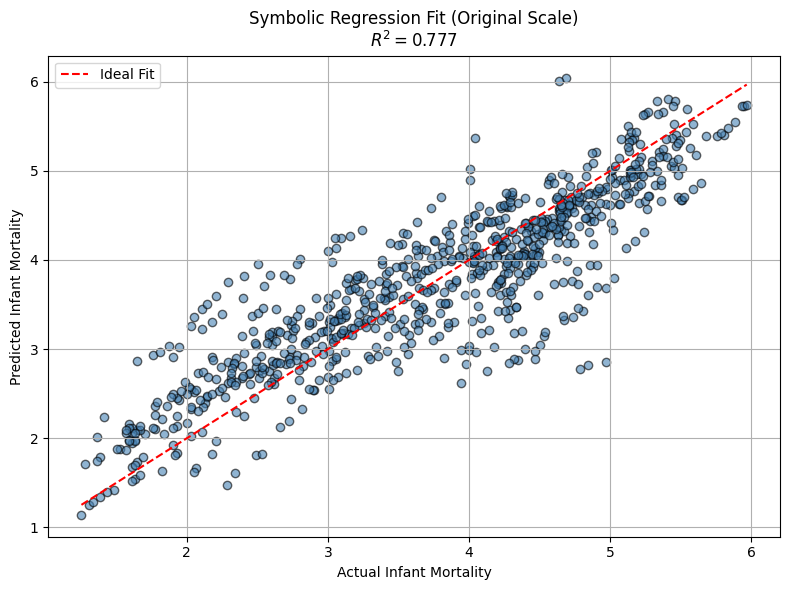

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set (still on log scale)
y_pred = model.predict(X_test)
y_actual = y_test

# Calculate R^2 on original scale, if you want
from sklearn.metrics import r2_score
r2_orig = r2_score(y_actual, y_pred)

# Plot actual vs predicted (original scale)
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred, alpha=0.6, color='steelblue', edgecolor='k')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', label='Ideal Fit')
plt.xlabel("Actual Infant Mortality")
plt.ylabel("Predicted Infant Mortality")
plt.title(f"Symbolic Regression Fit (Original Scale)\n$R^2 = {r2_orig:.3f}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


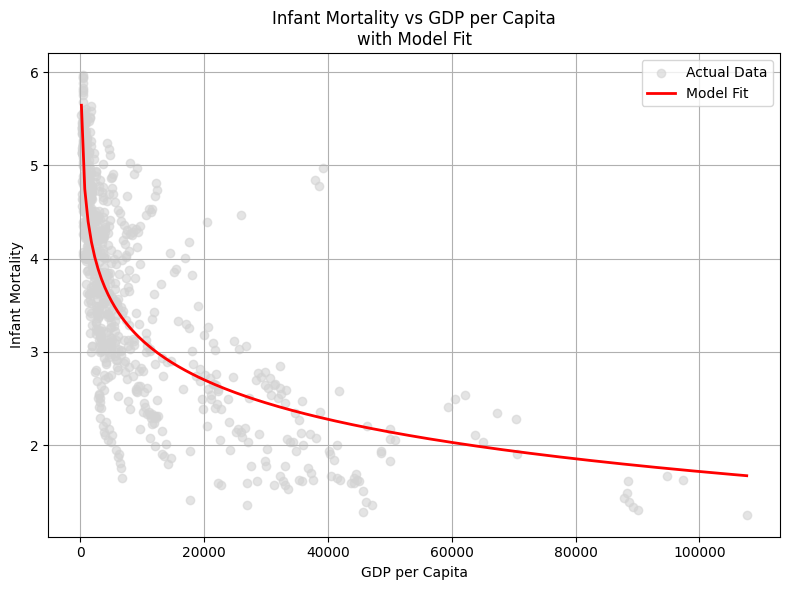

In [7]:
# X_test columns: 0=polity, 1=gdp_per_capita, 2=year, 3=pop_density
gdp = X_test[:, 1]  # gdp_per_capita

# Actual and predicted
y_actual = y_test
y_pred = model.predict(X_test)

# Scatter: Actual data (grey)
plt.figure(figsize=(8, 6))
plt.scatter(gdp, y_actual, alpha=0.6, color='lightgray', label="Actual Data")

# # Scatter: Model predictions (blue)
# plt.scatter(gdp, y_pred, alpha=0.7, color='steelblue', edgecolor='k', label="Model Predictions")

# Fit line: holding other features at their test means
gdp_range = np.linspace(gdp.min(), gdp.max(), 200)
# Use means from test set for other features
polity_mean = X_test[:, 0].mean()
year_mean = X_test[:, 2].mean()
pop_density_mean = X_test[:, 3].mean()

X_fit = np.column_stack([
    np.full_like(gdp_range, polity_mean),
    gdp_range,
    np.full_like(gdp_range, year_mean),
    np.full_like(gdp_range, pop_density_mean)
])
y_fit = model.predict(X_fit)

plt.plot(gdp_range, y_fit, 'r-', linewidth=2, label="Model Fit")

plt.xlabel("GDP per Capita")
plt.ylabel("Infant Mortality")
plt.title("Infant Mortality vs GDP per Capita\nwith Model Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import statsmodels.api as sm
from tabulate import tabulate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Prepare the design matrix and split
feature_names = ['polity', 'gdp_per_capita', 'year', 'pop_density']
X = df[feature_names]
y = np.log1p(df["inf_mort"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)


# Fit the OLS model
model = sm.OLS(y_train, X_train_sm).fit()

# Extract results similar to tidy() in R
results_df = pd.DataFrame({
    "Predictor": model.params.index,
    "B": model.params.values,
    "SE": model.bse.values,
    "t": model.tvalues.values,
    "p": model.pvalues.values
})
results_df = results_df.round({"B": 2, "SE": 3, "t": 2, "p": 3})

# Print as a pretty table (like kable)
print(tabulate(
    results_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))

# Print R^2 (out-of-sample on test set)
y_pred = model.predict(X_test_sm)
test_r2 = model.rsquared  # In-sample R^2 (train set)
from sklearn.metrics import r2_score
test_r2 = r2_score(y_test, y_pred)  # Out-of-sample R^2 (test set)
print(f"\nTest R²: {test_r2:.3f}")

# Show full model summary
print(model.summary())


| Predictor      |     B |    SE |      t |    p |
|----------------|-------|-------|--------|------|
| const          | 52.35 | 2.48  |  21.11 | 0    |
| polity         | -0.03 | 0.002 | -14.37 | 0    |
| gdp_per_capita | -0    | 0     | -38.04 | 0    |
| year           | -0.02 | 0.001 | -19.39 | 0    |
| pop_density    | -0    | 0     |  -1.34 | 0.18 |

Test R²: 0.582
                            OLS Regression Results                            
Dep. Variable:               inf_mort   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     786.6
Date:                Tue, 08 Jul 2025   Prob (F-statistic):               0.00
Time:                        15:13:37   Log-Likelihood:                -1933.9
No. Observations:                1899   AIC:                             3878.
Df Residuals:                    1894   BIC:                             3

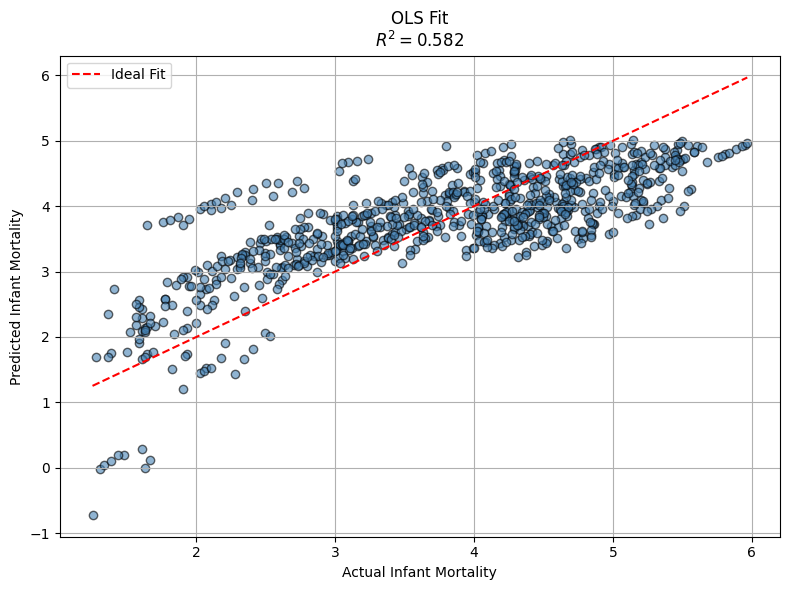

In [9]:
# Plot actual vs predicted for the test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='steelblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel("Actual Infant Mortality")
plt.ylabel("Predicted Infant Mortality")
plt.title(f"OLS Fit\n$R^2 = {test_r2:.3f}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **From Discovery to Inference: Testing Symbolic Regression in Political Science**

Now that we have discovered a predictive formula using symbolic regression, the next natural question is: **how do we evaluate its validity in a way that political scientists expect?** In political science, it’s standard to report *p*-values, confidence intervals, and effect sizes using regression models. While symbolic regression can uncover complex, nonlinear relationships, it does not directly provide these familiar inferential statistics.

**To bridge this gap**, we take the equation generated by symbolic regression (let’s call it $f(X)$), and treat it as a new variable summarizing the discovered relationship between our predictors and the outcome. We then fit a traditional linear regression:

$$
y = \alpha + \beta \cdot f(X) + \varepsilon
$$

This approach allows us to estimate the effect size of $f(X)$ on $y$, and to report classical inferential statistics (like *p*-values and confidence intervals) for this relationship.

---

#### **What does the code below do?**

1. **Parses** the symbolic regression formula into a mathematical function.
2. **Computes** $f(X)$ for every observation in the dataset.
3. **Fits** an ordinary least squares (OLS) regression where the outcome is regressed on this new variable $f(X)$.
4. **Outputs** the regression results, including the estimated coefficient, standard error, *p*-value, and confidence interval for $\beta$.

This lets us quantitatively assess the real-world relevance of the formula found by symbolic regression using the inferential tools familiar to political science.


In [10]:
import sympy as sp
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1. Parse the equation string from PySR
expr_str = best_eq
# Example: expr_str = '((year * -0.027083203) + 61.465336) - (gdp_per_capita ** 0.15634009)'

# 2. Define all variables as symbols
symbols = sp.symbols(feature_names)

# 3. Convert the string into a sympy expression
expr = sp.sympify(expr_str, locals={fn: sp.symbols(fn) for fn in feature_names})

# 4. Lambdify: turns the expression into a numpy function
f = sp.lambdify(symbols, expr, modules=['numpy'])

# 5. Calculate f(X) for your **entire dataframe**
f_X = f(*[df[fn].values for fn in feature_names])  # shape (n_samples,)

# 6. Add as new column if you want to inspect
df['symb_feat'] = f_X

# 7. Fit OLS: y = alpha + beta * f(X)
y = np.log1p(df["inf_mort"])
X_ols = sm.add_constant(df['symb_feat'])
ols_model = sm.OLS(y, X_ols).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:               inf_mort   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                 1.009e+04
Date:                Tue, 08 Jul 2025   Prob (F-statistic):               0.00
Time:                        15:13:37   Log-Likelihood:                -2000.9
No. Observations:                2713   AIC:                             4006.
Df Residuals:                    2711   BIC:                             4018.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.038     -0.055      0.9

### **Interpreting the Results: Classic Inference on Symbolic Regression Output**

After generating a predictive formula with symbolic regression, we tested its performance and statistical significance using a standard OLS regression, where the symbolic regression output ($f(X)$) is used as a single predictor for the outcome variable. This approach allows us to assess not only how well the discovered formula fits the data, but also whether its effect is statistically significant in the familiar language of political science (*p*-values, coefficients, R-squared).

In our results:

* The **coefficient** on the symbolic regression feature (`symb_feat`) is close to 1, indicating that the formula discovered by symbolic regression closely matches the true scale of the relationship in the data.
* The **p-value** is extremely low, providing strong evidence that our formula is a highly significant predictor of the outcome.
* The **R-squared** is high, suggesting that the symbolic regression formula captures most of the variation in the outcome variable.

**In summary:**
The symbolic regression model not only found a strong and meaningful relationship between predictors and outcome, but also stands up to classical statistical scrutiny. This demonstrates that machine-discovered formulas can yield results that are both interpretable and statistically robust—providing a powerful bridge between machine learning and the standards of inference in political science.


### **Interpreting Symbolic Regression: Classic Inference on Each Discovered Component**

Symbolic regression is powerful because it uncovers flexible, often nonlinear formulas that best capture the relationship between predictors and the outcome. However, political science research typically emphasizes *interpretable* models—ones where we can report p-values, confidence intervals, and the distinct effect of each explanatory variable or transformation.

To bridge these traditions, we take the formula found by symbolic regression and **decompose it into its component terms**—for example, if the discovered equation is:

$$
f(X) = 1.2 \cdot \sin(\text{polity}) + 0.8 \cdot \text{gdppercapita}^2
$$

we split the function into separate parts, such as $\sin(\text{polity})$ and $\text{gdppercapita}^2$. Each of these terms is calculated for all observations and included as its own variable in a traditional OLS regression:

$$
y = \alpha + \beta_1 \cdot \sin(\text{polity}) + \beta_2 \cdot \text{gdppercapita}^2 + \varepsilon
$$

This approach allows us to **estimate and interpret the effect of each discovered term individually**, reporting standard errors, p-values, and confidence intervals in the classic regression framework familiar to political science.

---

**What does the code below do?**

1. **Parses** the symbolic regression formula and splits it into its additive component terms.
2. **Computes** each term for every observation in the data.
3. **Fits** a traditional linear regression where each discovered component gets its own coefficient.
4. **Outputs** the regression summary, including the estimated effect, standard error, p-value, and confidence interval for each term.

This method combines the flexibility of symbolic regression with the interpretability and inference of classical regression analysis—making your findings both powerful and accessible to a social science audience.

In [12]:
def symbolic_terms_ols(best_eq, feature_names, df, target, log_transform=False):
    import sympy as sp
    import statsmodels.api as sm
    import numpy as np

    symbols = sp.symbols(feature_names)
    expr = sp.sympify(best_eq, locals={fn: sp.symbols(fn) for fn in feature_names})
    terms = expr.as_ordered_terms()

    term_cols = []
    for i, term in enumerate(terms):
        f = sp.lambdify(symbols, term, modules=['numpy'])
        colname = f'symb_term_{i+1}'
        df[colname] = f(*[df[fn].values for fn in feature_names])
        term_cols.append(colname)

    X = sm.add_constant(df[term_cols])
    y = np.log1p(df[target]) if log_transform else df[target]
    model = sm.OLS(y, X).fit()
    return model

# Usage:
ols_multi = symbolic_terms_ols(best_eq, feature_names, df, 'inf_mort', log_transform=True)
print(ols_multi.summary())



                            OLS Regression Results                            
Dep. Variable:               inf_mort   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     5051.
Date:                Tue, 08 Jul 2025   Prob (F-statistic):               0.00
Time:                        15:43:39   Log-Likelihood:                -1999.4
No. Observations:                2713   AIC:                             4005.
Df Residuals:                    2710   BIC:                             4023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
symb_term_1     0.9917      0.011     88.428      

### **Component-wise OLS: Interpreting Terms and Model Fit**

When we use the *individual components* of the symbolic regression formula as separate predictors in our OLS regression, several things can happen:

* **No Intercept:**
  If the symbolic regression formula includes a constant (e.g., a fixed number like “+ 61.46...”), this acts as the model’s intercept. In this case, OLS omits the redundant intercept term, since it’s already present among the predictors.

* **Coefficient Interpretation:**
  Each coefficient now reflects the partial effect of its associated symbolic term, giving us a clear interpretation of how each discovered component relates to the outcome.

* **R-squared Comparison:**
  The R² may be lower than when using the entire symbolic regression function as a single predictor. This is because the symbolic regression model is optimized for overall prediction, and splitting the terms allows OLS to re-estimate the optimal combination. If the symbolic regression already captured the relationship well, the gain from refitting each term is limited.

**In summary:**

* **Omitting the intercept is normal when a constant is in your predictors.**
* **The component-wise approach offers more detailed inference on each term,** at the potential cost of a slight reduction in overall fit compared to using the full formula as a single predictor.

---

**Tip:** If you want to always include an explicit intercept (and your symbolic formula has a constant), you can remove the constant from the formula before splitting into terms, or simply be aware that the constant term will take the role of the intercept in your output.
